Pull in the data for the water flow 

In [1]:
import pandas as pd
import csv
import requests
import os

In [2]:
# change to the path with the raw csv file
path=r'C:\Springboard\Github\River_Analysis'
os.chdir(path)

Instead of pulling this data from a CSV, we need to pull it directly from the USGS page (and maybe save it to a CSV)

In [3]:
### link to USGS data for each gage

# may need to pull the start and end dates first

# then pull the daily data using that start and end dates

# See 06_data_extraction from gauge_info


# pull in the CSV data that we already have for Eagle River at Avon
raw_file = '09066325.csv'

# read the raw CSV back in and remove the commented lines
# open raw CSV
fi = open(raw_file, 'r')

# read raw CSV to clean CSV - eliminate comment rows with "#"
clean_file = 'clean.csv'
with open(clean_file, 'w') as fo:
    lines = fi.readlines()
    for line in lines:
        if "#" not in line:
            fo.write(line)
fi.close()

In [4]:
# load daily water flow into a DF
flow = pd.read_csv(clean_file, error_bad_lines=False, delimiter='\t')
flow

,agency_cd,site_no,datetime,18601_00060_00003,18601_00060_00003_cd
0,5s,15s,20d,14n,10s
1,USGS,09066325,1999-10-01,34.0,A:e
2,USGS,09066325,1999-10-02,33.0,A:e
3,USGS,09066325,1999-10-03,31.0,A:e
4,USGS,09066325,1999-10-04,29.0,A:e
...,...,...,...,...,...
7908,USGS,09066325,2021-05-25,256,P
7909,USGS,09066325,2021-05-26,251,P
7910,USGS,09066325,2021-05-27,244,P
7911,USGS,09066325,2021-05-28,279,P


That looks pretty good. I would like to include more of the summer, but that can happen later. Let's drop some of the useless columns and rows.

In [5]:
# drop the first row - that looks like useless data
flow.drop(0, inplace=True)
flow

,agency_cd,site_no,datetime,18601_00060_00003,18601_00060_00003_cd
1,USGS,09066325,1999-10-01,34.0,A:e
2,USGS,09066325,1999-10-02,33.0,A:e
3,USGS,09066325,1999-10-03,31.0,A:e
4,USGS,09066325,1999-10-04,29.0,A:e
5,USGS,09066325,1999-10-05,29.0,A:e
...,...,...,...,...,...
7908,USGS,09066325,2021-05-25,256,P
7909,USGS,09066325,2021-05-26,251,P
7910,USGS,09066325,2021-05-27,244,P
7911,USGS,09066325,2021-05-28,279,P


In [6]:
# rename columns to make for easier dropping
flow.columns = ['agency', 'gage', 'date', 'y', 'useless']
flow

,agency,gage,date,y,useless
1,USGS,09066325,1999-10-01,34.0,A:e
2,USGS,09066325,1999-10-02,33.0,A:e
3,USGS,09066325,1999-10-03,31.0,A:e
4,USGS,09066325,1999-10-04,29.0,A:e
5,USGS,09066325,1999-10-05,29.0,A:e
...,...,...,...,...,...
7908,USGS,09066325,2021-05-25,256,P
7909,USGS,09066325,2021-05-26,251,P
7910,USGS,09066325,2021-05-27,244,P
7911,USGS,09066325,2021-05-28,279,P


In [7]:
flow.drop(['agency', 'gage', 'useless'], axis=1, inplace=True)
flow

,date,y
1,1999-10-01,34.0
2,1999-10-02,33.0
3,1999-10-03,31.0
4,1999-10-04,29.0
5,1999-10-05,29.0
...,...,...
7908,2021-05-25,256
7909,2021-05-26,251
7910,2021-05-27,244
7911,2021-05-28,279


In [8]:
flow['y'] = flow['y'].astype(float)

In [9]:
# let's check for NaN values
flow['y'].isna().value_counts()

False    7911
True        1
Name: y, dtype: int64

In [ ]:
# instead of assuming it's all filled, let's fill it
# let's check for NaN values
flow['y'].isna().value_counts()

that looks all filled to me. Time to rename the date column and run FB prophet

In [10]:
flow.rename(columns={'date':'ds'}, inplace=True)

Next steps: how do I get the min / max / median / mean from each independent calendar day? <br>
<br>
Perhaps group by month and day

In [11]:
# add day and month columns to the existing DF
flow["Month"] = flow['ds'].str[5:7]
flow["Day"] = flow['ds'].str[8:10]
flow['MD'] = flow["Month"] + '-' + flow["Day"]

In [12]:
flow.dtypes

ds        object
y        float64
Month     object
Day       object
MD        object
dtype: object

In [13]:
flow['Month'] = flow['Month'].astype(int)
flow['Day'] = flow['Day'].astype(int)

In [14]:
summary = flow.groupby(["MD"], as_index=False)['y'].agg(['mean', 'min', 'median', 'max'])
summary

,mean,min,median,max
MD,,,,
01-01,18.404545,12.6,18.10,24.1
01-02,18.018182,10.8,17.60,24.0
01-03,18.190909,11.2,17.95,25.7
01-04,18.418182,10.0,17.75,29.0
01-05,18.090909,11.3,17.80,24.3
...,...,...,...,...
12-27,18.377273,11.0,18.35,23.2
12-28,18.590909,11.5,18.35,24.4
12-29,18.600000,10.1,18.90,23.8


In [15]:
# let's check these values
summary.describe()

,mean,min,median,max
count,366.000000,366.000000,366.000000,366.000000
mean,112.320842,32.182623,99.264071,270.280601
std,176.216790,43.245170,164.055652,423.581849
min,16.581818,8.620000,16.100000,20.800000
25%,18.586023,12.000000,18.750000,25.900000
50%,29.802273,13.500000,26.075000,63.700000
75%,88.881656,24.450000,75.162500,220.750000
max,748.190476,226.000000,801.000000,1730.000000


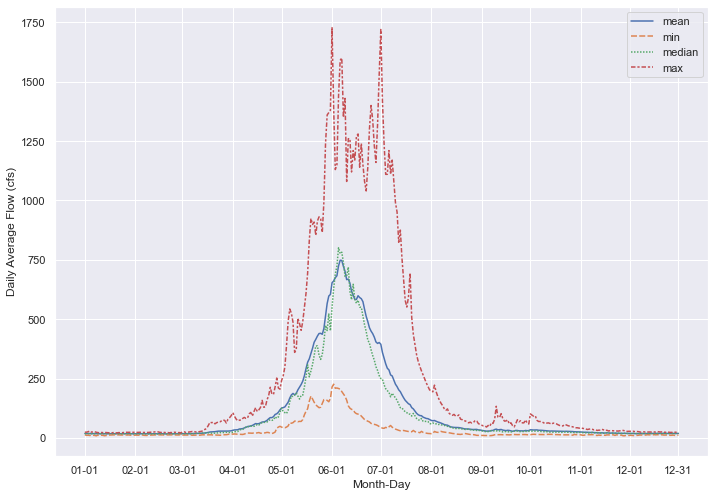

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
# set the figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
# create the plot
g  = sns.lineplot(data=summary) # , x='MD', y=['min', 'mean', 'max', 'median'])
_ = plt.xticks(['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01', '12-31'])
plt.xlabel('Month-Day')
plt.ylabel('Daily Average Flow (cfs)')
plt.savefig('Gore_Creek.png',bbox_inches='tight')
# g.set_xticks(25)

# g.set_xticklabels(['0','a','b','c','d','e'])
# need to resize
# need to space the markers out more
# need to save this plot so we can add it to a HTML site